# Effortless NLP using HuggingFace's Tranformers Ecosystem

![Image](https://raw.githubusercontent.com/RajkumarGalaxy/dataset/master/Images/z0001.jpg)

> Image by [Author](https://raw.githubusercontent.com/RajkumarGalaxy/dataset/master/Images/z0001.jpg)
### How to finetune a model on a custom dataset?

#### ------------------------------------------------ 
#### *Articles So Far In This Series*
#### -> [[NLP Tutorial] Finish Tasks in Two Lines of Code](https://www.kaggle.com/rajkumarl/nlp-tutorial-finish-tasks-in-two-lines-of-code)
#### -> [[NLP Tutorial] Unwrapping Transformers Pipeline](https://www.kaggle.com/rajkumarl/nlp-unwrapping-transformers-pipeline)
#### -> [[NLP Tutorial] Exploring Tokenizers](https://www.kaggle.com/rajkumarl/nlp-tutorial-exploring-tokenizers)
#### -> [[NLP Tutorial] Fine-Tuning in TensorFlow](https://www.kaggle.com/rajkumarl/nlp-tutorial-fine-tuning-in-tensorflow) 
#### -> [[NLP Tutorail] Fine-Tuning in Pytorch](https://www.kaggle.com/rajkumarl/nlp-tutorial-fine-tuning-in-pytorch) 
#### -> [[NLP Tutorail] Fine-Tuning with Trainer API](https://www.kaggle.com/rajkumarl/nlp-tutorial-fine-tuning-with-trainer-api) 
#### ------------------------------------------------ 

# Prepare Environment and Data

In this article we discuss fine-tuning a BERT model on the famous SST2 dataset using TensorFlow and Keras. This requires a GPU environment for faster training and inference.

In [1]:
# upgrade transformers and datasets to latest versions
!pip install --upgrade transformers
!pip install --upgrade datasets

import transformers
import datasets
print(transformers.__version__)
print(datasets.__version__)

     |████████████████████████████████| 3.1 MB 893 kB/s 
     |████████████████████████████████| 59 kB 5.6 MB/s 
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.14.0 requires huggingface-hub<0.1.0,>=0.0.19, but you have huggingface-hub 0.1.2 which is incompatible.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 4.12.5 which is incompatible.
     |████████████████████████████████| 298 kB 890 kB/s 
  Attempting uninstall: datasets
    Found existing installation: da

In [2]:
# Make necessary imports

# for array operations 
import numpy as np 
# TensorFlow framework
import tensorflow as tf
# for modeling and training
from tensorflow import keras
# for pretty printing
from pprint import pprint
# plotting
from matplotlib import pyplot as plt

# HuggingFace ecosystem
from transformers import AutoTokenizer, \
                        DataCollatorWithPadding, \
                        TFAutoModelForSequenceClassification
from datasets import load_dataset

# a seed for reproducibility
SEED = 42
# set seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

# check for GPU device
print('Number of CPU Devices: ', len(tf.config.list_physical_devices('CPU')))
print('Number of GPU Devices: ', len(tf.config.list_physical_devices('GPU')))

Number of CPU Devices:  1
Number of GPU Devices:  1


2021-11-30 12:57:09.694689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:57:09.695734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:57:09.696401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Load the SST-2 Dataset from GLUE benchmark

In [3]:
raw_data = load_dataset("glue", "sst2")
# how does it look like?
raw_data

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.44M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [4]:
# Sample a data
raw_data["train"][0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

Each data point contains a sentence, its index and its label. What labels are there? What are their positions?

In [5]:
raw_data["train"].features

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['negative', 'positive'], names_file=None, id=None),
 'idx': Value(dtype='int32', id=None)}

We understand that this dataset consists of the supervised task - *Sentiment Analysis* with 2 classes: negative [0] and positive [1] 

# Tokenizer and Data Collator

We are about to use a pre-trained Bert_base_uncased model for our fine-tuning. A tokenizer function associated with a data collator can ensure efficient memory usage and quick data handling during training.

In [6]:
checkpoint = 'bert-base-uncased'
# bert tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint, return_tensors='tf')
# data collator for dynamic padding as per batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [7]:
# define a tokenize function
def Tokenize_function(example):
    return tokenizer(example['sentence'], truncation=True)

In [8]:
# tokenize entire data
tokenized_data = raw_data.map(Tokenize_function, batched=True)

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

How does tokenized data look like?

In [9]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence', 'token_type_ids'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence', 'token_type_ids'],
        num_rows: 872
    })
    test: Dataset({
        features: ['attention_mask', 'idx', 'input_ids', 'label', 'sentence', 'token_type_ids'],
        num_rows: 1821
    })
})

Let's convert the dataset from HF Dataset format to TensorFlow Dataset for convenience.

In [10]:
# set format
tokenized_data["train"].set_format(type='tf', columns=['attention_mask', 'input_ids', 'token_type_ids', 'label'])
# rename label as labels, as expected by tf models
tokenized_data["train"].rename_column_('label', 'labels')
# set format
tokenized_data["validation"].set_format(type='tf', columns=['attention_mask', 'input_ids', 'token_type_ids', 'label'])
# make the renaming
tokenized_data["validation"].rename_column_('label', 'labels')
# inspect it
tokenized_data["train"].format

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: rename_column_ is deprecated and will be removed in the next major version of datasets. Use Dataset.rename_column instead.
  after removing the cwd from sys.path.


{'type': 'tensorflow',
 'format_kwargs': {},
 'columns': ['attention_mask', 'input_ids', 'token_type_ids', 'labels'],
 'output_all_columns': False}

`attention_mask`, `input_ids`, `token_type_ids` are the necessary input features and `label` is the target. Other features are useless in the view of modeling.

In [11]:
# convert to TF dataset
# train set
train_data = tokenized_data["train"].to_tf_dataset( 
    columns = ['attention_mask', 'input_ids', 'token_type_ids'], 
    label_cols = ['labels'], 
    shuffle = True, 
    collate_fn = data_collator, 
    batch_size = 8 
)
# validation set
val_data = tokenized_data["validation"].to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['labels'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8
)
# check whether it is a TF's PrefetchDataset
train_data

2021-11-30 12:57:25.230298: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-30 12:57:25.231843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:57:25.232664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:57:25.233304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

<PrefetchDataset shapes: ({attention_mask: (8, None), input_ids: (8, None), token_type_ids: (8, None)}, (8,)), types: ({attention_mask: tf.int64, input_ids: tf.int64, token_type_ids: tf.int64}, tf.int64)>

Data is ready now for efficient data loading and faster training.

# Model Fine-tuning

In [12]:
EPOCHS = 3
TRAINING_STEPS = len(train_data) * EPOCHS

# define a learning rate scheduler
lr_scheduler = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5, 
    end_learning_rate=0.0,
    decay_steps=TRAINING_STEPS
)

# define an Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=lr_scheduler)

# define loss function
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# build model

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

# compile model
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

# What layers, parameters are there in the model
model.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train the model
hist = model.fit(
    train_data,
    validation_data = val_data,
    epochs = EPOCHS
)

2021-11-30 12:57:56.707578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3
8418/8418 [==============================] - 656s 76ms/step - loss: 0.2293 - accuracy: 0.9122 - val_loss: 0.3046 - val_accuracy: 0.9002
Epoch 2/3
8418/8418 [==============================] - 647s 77ms/step - loss: 0.1134 - accuracy: 0.9620 - val_loss: 0.2481 - val_accuracy: 0.9128
Epoch 3/3
8418/8418 [==============================] - 645s 77ms/step - loss: 0.0572 - accuracy: 0.9812 - val_loss: 0.2692 - val_accuracy: 0.9128


# Performance Analysis

Plots are always great in providing insights. Let's have a look at the training curve by plotting accuracies and losses.

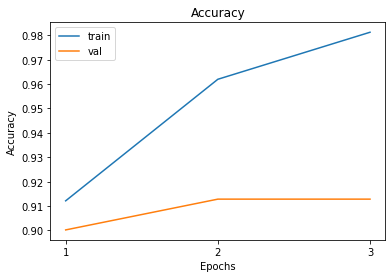

In [14]:
# plotting accuracy
history = hist.history
plt.plot(range(1,4), history["accuracy"], label='train')
plt.plot(range(1,4), history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.xticks([1,2,3])
plt.legend()
plt.show()

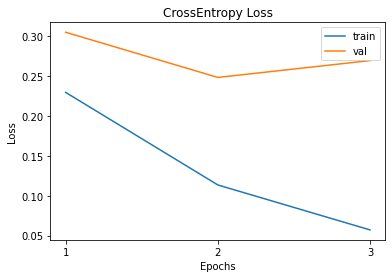

In [15]:
# plotting losses
history = hist.history
plt.plot(range(1,4), history["loss"], label='train')
plt.plot(range(1,4), history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks([1,2,3])
plt.title('CrossEntropy Loss')
plt.legend()
plt.show()

# Prediction 

Predict the labels for the test data. Prepare the test set as TF dataset object.

In [16]:
# set format
tokenized_data['test'].set_format(type='tf', 
                                 columns=['input_ids','token_type_ids','attention_mask','label']
                                 )
# rename label as labels
tokenized_data['test'].rename_column_('label','labels')
# convert to TF Dataset
test_data = tokenized_data["test"].to_tf_dataset(
    columns=['input_ids','token_type_ids','attention_mask'],
    label_cols=['labels'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8
)

In [17]:
preds = model.predict(test_data)["logits"]
label_preds = np.argmax(preds, axis=1)
label_preds.shape 

(1821,)

### That's the end. We got a good understanding of fine-tuning a BERT model on a sentiment analysis dataset in TensorFlow!

##### Key reference: [HuggingFace's NLP Course](https://huggingface.co/course)

### Thank you for your valuable time!